# DDPG Variant

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app",seed=1,no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain_name)

TennisBrain


### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
#print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24


### 3. DDPG variant

A variant of DDPG is implemented here. Actor receives all states of the environment to decide his action and Critic also receives all states / all actions of the environment to determine Q value. Experienced Replay Buffer is used to effectively train the agent and to reduce correlations among experiences.


In [5]:
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Actor/Critic model- reference - Udacity - DDPG pendulam project
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor Model - Used to update policy."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size*2, fc1_units)        
        self.fc2 = nn.Linear(fc1_units, fc2_units)        
        self.fc3 = nn.Linear(fc2_units, action_size)        
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)        

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""        
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic Model - used to evaluate Value"""

    def __init__(self, state_size, action_size, seed, fcs1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size*2, fcs1_units)            
        self.fc2 = nn.Linear(fcs1_units+ (action_size*2), fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)                
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)       

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""        
        xs = F.leaky_relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)


In [7]:
# Agent Model with replay buffer and OU noise - reference: Udacity - DDPG pendulam  project
import numpy as np
import random
import copy
from collections import namedtuple, deque


import torch
import torch.nn.functional as F
import torch.optim as optim


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size,  random_seed):        
        self.state_size = state_size
        self.action_size = action_size        
        self.seed = random.seed(random_seed)
        self.batch_size = BATCH_SIZE   
        self.t_step = 0
        self.seed = random.seed(random_seed)
        self.decay_step = 0

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        self.memory =  ReplayBuffer(BATCH_SIZE, BUFFER_SIZE, random_seed)
        
        # update target networks
        #self.soft_update(self.critic_local, self.critic_target, 1.0)
        #self.soft_update(self.actor_local, self.actor_target, 1.0)
        
        # Noise process
        #self.noise = OUNoise()
        self.noise = OUNoise( action_size , random_seed)
       
      
    def step(self, state, action, reward, next_state, done,agent_number, beta):
        """Save experience in replay memory, and use random sample from buffer to learn."""        
        # Save experience / reward                                       
        self.memory.add(state, action, reward, next_state, done)            
       
        # Learn, if enough samples are available in memory  
        # Learn every UPDATE_EVERY time steps.
        self.t_step +=1
        
        if self.t_step %UPDATE_EVERY == 0:
            if self.memory.is_filled():                
                self.learn(agent_number, GAMMA,beta) 
    
   
     
    
    def numpy_to_torch(self,data):
        return torch.from_numpy(data).float().to(device)
                                
    def act(self, state, episode_num, add_noise=True ):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)                  
        self.actor_local.eval()
        with torch.no_grad():              
            action = self.actor_local(state).cpu().data.numpy()                                            
        self.actor_local.train()               
        if add_noise:                   
            action = self.add_random_noise(action,episode_num)
            #action +=  noise_decay * self.noise.sample() #self.add_random_noise()          
        return np.clip(action, -1, 1)
    
    def noise_decay_schedule(self,episode_num):  
        return max(0.0, NOISE_SCALE * (1 - (episode_num / NOISE_DECAY_LIMIT)))

    def add_random_noise(self,action,episode_num):  
        if episode_num < 500:
            return np.random.randn(1,self.action_size)
        action +=  self.noise_decay_schedule(episode_num) * self.noise.sample()
        return action
        
        #self.decay_step+=1
        #explore_probability = GREEDY_EPSILON_MIN + ( GREEDY_EPSILON - GREEDY_EPSILON_MIN) * np.exp(-GREEDY_EPSILON_DECAY * self.decay_step)
        #explore_probability = GREEDY_EPSILON
        #if explore_probability > np.random.rand():
            # Make a random action (exploration)
        #    return np.random.randn(1,self.action_size)
        #else:
        #    action +=  noise_decay * self.noise.sample()
        #    return action
        
    
    def reset(self):        
        self.noise.reset()
    
    def learn(self, agent_number, gamma,beta):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """                        
                                                  
        states, actions, rewards, next_states, dones = self.memory.sample()
        #states, actions, rewards, next_states, dones ,indices,weights = self.memory.sample(beta)       
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
                            
        actions_next = self.actor_target(next_states)
        if agent_number == 0:                     
            actions_next = torch.cat((actions_next, actions[:,2:]), dim=1)
        else:       
            #actions_next = self.actor_target(next_states[:,self.state_size:])
            actions_next = torch.cat((actions[:,:2], actions_next), dim=1)
            
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (GAMMA * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)                        

        # Minimize the loss

        #critic_loss = (torch.FloatTensor(weights) * F.mse_loss(Q_expected, Q_targets)).mean()            
        critic_loss =  F.mse_loss(Q_expected, Q_targets)
        #huber_loss=torch.nn.SmoothL1Loss()        
        #critic_loss=huber_loss(Q_expected, Q_targets.detach())
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss                 
        actions_pred = self.actor_local(states)
        if agent_number == 0:                    
            actions_pred = torch.cat((actions_pred, actions[:,2:]), dim=1)
        else:            
            #actions_pred = self.actor_local(states[:,self.state_size:])
            actions_pred = torch.cat((actions[:,:2], actions_pred), dim=1)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #        
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU) 
                           

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.13, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state        
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

    
class ReplayBuffer:    

    def __init__(self, batch_size, buffer_size, seed):
        """Initialize a ReplayBuffer object."""
        
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def is_filled(self):
        """Return the current size of internal memory."""
        return len(self.memory) >= self.batch_size
    
    

In [8]:
class MADDPGAgent():
    def __init__(self,state_size,action_size,num_agents,random_seed):        
        self.agents = [Agent(state_size, action_size,  random_seed) for _ in range(num_agents)]
        self.num_agents = num_agents
        self.total_state_size = state_size*num_agents 
        self.total_action_size = action_size * num_agents
        self.t_step = 0
    
    def reset(self):
        for agent in self.agents:
            agent.reset()
    
    def act(self,states,episode_num):        
        all_states = np.reshape(states, (1,self.total_state_size))             
        #actions = [self.agents[agent_num].act(state, episode_num) for agent_num,state in enumerate(states)]        
        actions = [self.agents[agent_num].act(all_states, episode_num) for agent_num in range(self.num_agents)] 
        actions = np.reshape(actions, (1,self.total_action_size))          
        return actions
        

    def step(self,states,actions,rewards,next_states,dones,beta):   
        states = np.reshape(states, (1,self.total_state_size))
        actions = np.reshape(actions, (1,self.total_action_size))
        next_states = np.reshape(next_states,(1,self.total_state_size))
        for agent_num in range(self.num_agents):
            self.agents[agent_num].step(states,actions,rewards[agent_num],next_states,dones[agent_num],agent_num,beta)        
                              
    def save_checkpt(self):
        torch.save(self.agents[0].actor_local.state_dict(), 'checkpoint_actor1_ddpgv.pth')
        torch.save(self.agents[0].critic_local.state_dict(), 'checkpoint_critic1_ddpgv.pth')
        torch.save(self.agents[1].actor_local.state_dict(), 'checkpoint_actor2_ddpgv.pth')
        torch.save(self.agents[1].critic_local.state_dict(), 'checkpoint_critic2_ddpgv.pth')

In [9]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 512        # minibatch size
GAMMA = 0.95            # discount factor
TAU = 0.05              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
UPDATE_EVERY = 1
NO_UPDATES = 1



EPSILON = 1e-5 # small amount to avoid zero priority
ALPHA = 0.6 # to adjust weight of TD error. PER 1 = full prioritization, 0 = no prioritization
TOTAL_EPISODES=10000
NOISE_SCALE = 1
NOISE_DECAY_LIMIT=1200
BETA_EPISODES_LIMIT = 2000

GREEDY_EPSILON = 0.01 #1.0 # exploration probability at start
GREEDY_EPSILON_MIN = 0.01  
GREEDY_EPSILON_DECAY= 0.0005 # exponential decay rate for exploration prob


In [10]:
agent = MADDPGAgent(state_size, action_size,num_agents,  0) 

def scale_beta(episode_num):
    return min(1.0, ( episode_num / BETA_EPISODES_LIMIT))                            
    
def noise_decay_schedule(episode_num):  
    return max(0.0, NOISE_SCALE * (1 - (episode_num / NOISE_DECAY_LIMIT)))


In [11]:
def maddpg(n_episodes=TOTAL_EPISODES, max_t=100, print_every=200):
    scores_deque = deque(maxlen=100)
    all_scores = []
    rolling_avg_100 = []    
    total_state_size = state_size*num_agents 
    total_action_size = action_size * num_agents
    
    for i_episode in range(1, n_episodes+1):
        #noise_decay = noise_decay_schedule(i_episode)
        beta = scale_beta(i_episode)
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations        
        agent.reset()
        scores = np.zeros(num_agents)
        
        while True: 
            actions = agent.act(states,i_episode)              
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations   # get the next state            
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done                 # see if episode has finished                                     
            agent.step(states,actions,rewards,next_states,dones,beta)            
            scores += rewards                                # update the score
            states = next_states                                            
            
            if np.any(dones):
                break
            
                                   
        max_score = np.max(scores)        
        scores_deque.append(max_score)
        all_scores.append(max_score)   
        rolling_avg_100.append(np.mean(scores_deque))
        print('\rEpisode {} Episode Score:{:.2f} \tAverage Score: {:.3f}'.format(i_episode, max_score, np.mean(scores_deque)), end="")        
        if i_episode % print_every == 0:
            print('\rEpisode {}\t  Episode Score:{:.2f} \t Average Score: {:.3f}'.format(i_episode, max_score,np.mean(scores_deque)))
                           
        if np.mean(scores_deque)>=0.5:                    
            agent.save_checkpt()
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode-100, np.mean(scores_deque)))            
            break
         
    env.close()
    return all_scores,rolling_avg_100

scores,rolling_mean = maddpg()

Episode 200	  Episode Score:0.00 	 Average Score: 0.017
Episode 400	  Episode Score:0.10 	 Average Score: 0.019
Episode 600	  Episode Score:0.00 	 Average Score: 0.045
Episode 800	  Episode Score:0.09 	 Average Score: 0.075
Episode 1000	  Episode Score:0.10 	 Average Score: 0.101
Episode 1200	  Episode Score:0.10 	 Average Score: 0.128
Episode 1400	  Episode Score:0.19 	 Average Score: 0.190
Episode 1600	  Episode Score:0.20 	 Average Score: 0.424
Episode 1727 Episode Score:1.60 	Average Score: 0.506
Environment solved in 1627 episodes!	Average Score: 0.506


In [12]:
def plot_result(scores,mean_scores):
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.plot(np.arange(len(mean_scores)), mean_scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

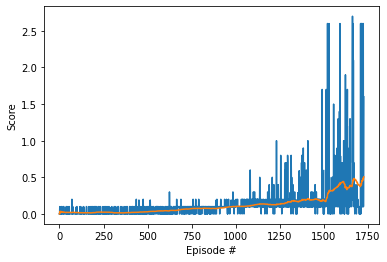

In [13]:
plot_result(scores,rolling_mean)